In [1]:
import gzip

import numpy as np
import matplotlib.pyplot as plt

from Bio import SeqIO, SeqUtils

%matplotlib inline

In [2]:
!rm -f atroparvus.fa.gz gambiae.fa.gz 2>/dev/null
!wget ftp://ftp.vectorbase.org/public_data/organism_data/agambiae/Genome/agambiae.CHROMOSOMES-PEST.AgamP3.fa.gz -O gambiae.fa.gz
!wget https://www.vectorbase.org/download/anopheles-atroparvus-ebroscaffoldsaatre1fagz -O atroparvus.fa.gz


--2018-05-18 16:19:29--  ftp://ftp.vectorbase.org/public_data/organism_data/agambiae/Genome/agambiae.CHROMOSOMES-PEST.AgamP3.fa.gz
           => ‘gambiae.fa.gz’
Resolving ftp.vectorbase.org (ftp.vectorbase.org)... 129.74.255.228
Connecting to ftp.vectorbase.org (ftp.vectorbase.org)|129.74.255.228|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /public_data/organism_data/agambiae/Genome ... done.
==> SIZE agambiae.CHROMOSOMES-PEST.AgamP3.fa.gz ... 81591806
==> PASV ... done.    ==> RETR agambiae.CHROMOSOMES-PEST.AgamP3.fa.gz ... done.
Length: 81591806 (78M) (unauthoritative)

agambiae.CHROMOSOME 100%[===================>]  77.81M  52.9MB/s    in 1.5s    

2018-05-18 16:19:31 (52.9 MB/s) - ‘gambiae.fa.gz’ saved [81591806]

--2018-05-18 16:19:32--  https://www.vectorbase.org/download/anopheles-atroparvus-ebroscaffoldsaatre1fagz
Resolving www.vectorbase.org (www.vectorbase.org)... 129.74.255.228
Connecting t

In [3]:
gambiae_name = 'gambiae.fa.gz'
atroparvus_name = 'atroparvus.fa.gz'

In [4]:
recs = SeqIO.parse(gzip.open(gambiae_name, 'rt', encoding='utf-8'), 'fasta')
for rec in recs:
    print(rec.description)
#Do not do this with atroparvus

chromosome:AgamP3:2L:1:49364325:1 chromosome 2L
chromosome:AgamP3:2R:1:61545105:1 chromosome 2R
chromosome:AgamP3:3L:1:41963435:1 chromosome 3L
chromosome:AgamP3:3R:1:53200684:1 chromosome 3R
chromosome:AgamP3:UNKN:1:42389979:1 chromosome UNKN
chromosome:AgamP3:X:1:24393108:1 chromosome X
chromosome:AgamP3:Y_unplaced:1:237045:1 chromosome Y_unplaced


In [5]:
recs = SeqIO.parse(gzip.open(gambiae_name, 'rt', encoding='utf-8'), 'fasta')
chrom_Ns = {}
chrom_sizes = {}
for rec in recs:
    chrom = rec.description.split(':')[2]
    if chrom in ['UNKN', 'Y_unplaced']:
        continue
    chrom_Ns[chrom] = []
    on_N = False
    curr_size = 0
    for pos, nuc in enumerate(rec.seq):
        if nuc in ['N', 'n']:
            curr_size += 1
            on_N = True
        else:
            if on_N:
                chrom_Ns[chrom].append(curr_size)
                curr_size = 0
            on_N = False
    if on_N:
        chrom_Ns[chrom].append(curr_size)
    chrom_sizes[chrom] = len(rec.seq)

In [6]:
for chrom, Ns in chrom_Ns.items():
    size = chrom_sizes[chrom]
    print('%s (%s): %%Ns (%.1f), num Ns: %d, max N: %d' % (chrom, size, 100 * sum(Ns) / size, len(Ns), max(Ns)))

2L (49364325): %Ns (1.7), num Ns: 957, max N: 28884
2R (61545105): %Ns (2.3), num Ns: 1658, max N: 36427
3L (41963435): %Ns (2.9), num Ns: 1272, max N: 31063
3R (53200684): %Ns (1.8), num Ns: 1128, max N: 24292
X (24393108): %Ns (4.1), num Ns: 1287, max N: 21132


## Atroparvus super-contigs

In [7]:
recs = SeqIO.parse(gzip.open(atroparvus_name, 'rt', encoding='utf-8'), 'fasta')
sizes = []
size_N = []
for rec in recs:
    size = len(rec.seq)
    sizes.append(size)
    count_N = 0
    for nuc in rec.seq:
        if nuc in ['n', 'N']:
            count_N += 1
    size_N.append((size, count_N / size))

In [8]:
print(len(sizes), np.median(sizes), np.mean(sizes), max(sizes), min(sizes),
      np.percentile(sizes, 10), np.percentile(sizes, 90))

1371 8304.0 163596.0065645514 20238125 1004 1563.0 56612.0


Text(0.5,0.98,'Fraction of Ns per contig size')

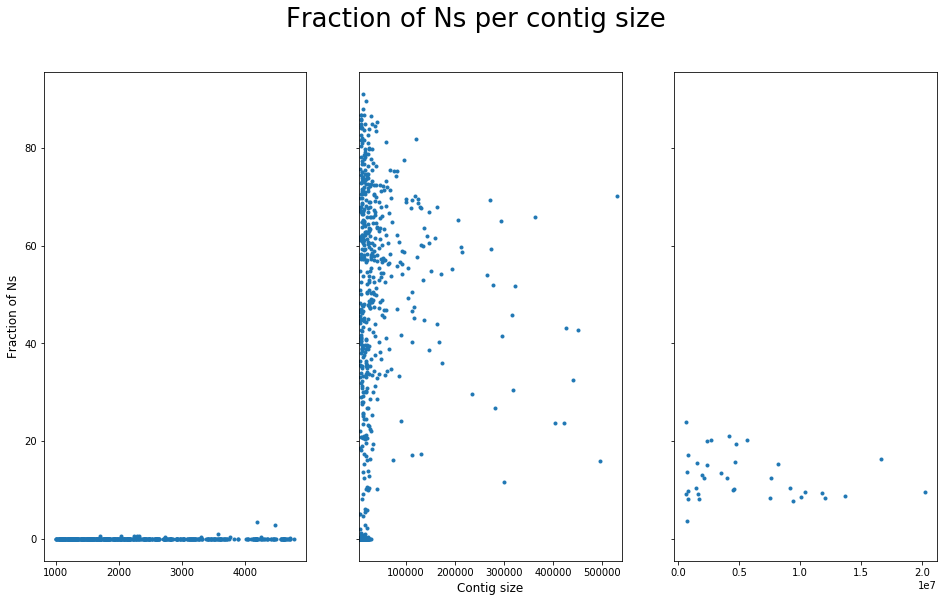

In [12]:
small_split = 4800
large_split = 540000
fig, axs = plt.subplots(1, 3, figsize=(16, 9), squeeze=False, sharey=True)
xs, ys = zip(*[(x, 100 * y) for x, y in size_N if x <= small_split])
axs[0, 0].plot(xs, ys, '.')
xs, ys = zip(*[(x, 100 * y) for x, y in size_N if x > small_split and x <= large_split])
axs[0, 1].plot(xs, ys, '.')
axs[0, 1].set_xlim(small_split, large_split)
xs, ys = zip(*[(x, 100 * y) for x, y in size_N if x > large_split])
axs[0, 2].plot(xs, ys, '.')
axs[0, 0].set_ylabel('Fraction of Ns', fontsize=12)
axs[0, 1].set_xlabel('Contig size', fontsize=12)
fig.suptitle('Fraction of Ns per contig size', fontsize=26)